In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.4
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0843

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - loss: 0.0659
Average validation loss: 0.6771768927574158
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - loss: 0.0659 - val_loss: 0.6772
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step - loss: 0.0506 - val_loss: 0.6772
Average validation loss: 0.6283589601516724
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 501ms/step - loss: 0.0506 - val_loss: 0.6528
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 495ms/step - loss: 0.0392 - val_loss: 0.6528
Average validation loss: 0.5037039518356323
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 508ms/step - loss: 0.0392 - val_loss: 0.6031
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segfo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 798ms/step - loss: 1.8105e-05
Average validation loss: 0.1727440021932125
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 807ms/step - loss: 1.8105e-05 - val_loss: 0.1727
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 843ms/step - loss: 1.7053e-05 - val_loss: 0.1727
Average validation loss: 0.10589335486292839
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 852ms/step - loss: 1.7053e-05 - val_loss: 0.1393
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 816ms/step - loss: 1.6120e-05 - val_loss: 0.1393
Average validation loss: 0.07633079960942268
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 824ms/step - loss: 1.6120e-05 - val_loss: 0.1183
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 801ms/step - loss: 5.9184e-06
Average validation loss: 0.02304801469047864
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 811ms/step - loss: 5.9184e-06 - val_loss: 0.0230
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 837ms/step - loss: 5.3738e-06 - val_loss: 0.0230
Average validation loss: 0.04029591754078865
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 849ms/step - loss: 5.3738e-06 - val_loss: 0.0317
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 833ms/step - loss: 5.0136e-06 - val_loss: 0.0317
Average validation loss: 0.01945408247411251
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 841ms/step - loss: 5.0136e-06 - val_loss: 0.0276
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_15.pth'.
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 824ms/step - loss: 4.8046e

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 889ms/step - loss: 4.4909e-06
Average validation loss: 0.02805520547553897
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 900ms/step - loss: 4.4909e-06 - val_loss: 0.0281
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 777ms/step - loss: 4.0054e-06 - val_loss: 0.0281
Average validation loss: 0.01337292930111289
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 786ms/step - loss: 4.0054e-06 - val_loss: 0.0207
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 828ms/step - loss: 3.7110e-06 - val_loss: 0.0207
Average validation loss: 0.01992920716293156
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 838ms/step - loss: 3.7110e-06 - val_loss: 0.0205
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 801ms/step - loss: 3.3909e

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 816ms/step - loss: 3.3197e-06
Average validation loss: 0.016213904740288852
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 826ms/step - loss: 3.3197e-06 - val_loss: 0.0162
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 878ms/step - loss: 2.6008e-06 - val_loss: 0.0162
Average validation loss: 0.003928082576021552
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 889ms/step - loss: 2.6008e-06 - val_loss: 0.0101
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 952ms/step - loss: 2.2736e-06 - val_loss: 0.0101
Average validation loss: 0.03413708209991455
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 962ms/step - loss: 2.2736e-06 - val_loss: 0.0181
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 69s 800ms/step - loss: 2.026

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 785ms/step - loss: 1.5334e-06
Average validation loss: 0.00740010888936619
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 796ms/step - loss: 1.5334e-06 - val_loss: 0.0074
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 775ms/step - loss: 1.2284e-06 - val_loss: 0.0074
Average validation loss: 0.004894873990754907
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 786ms/step - loss: 1.2284e-06 - val_loss: 0.0061
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 789ms/step - loss: 1.0411e-06 - val_loss: 0.0061
Average validation loss: 0.0026908695387343564
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 803ms/step - loss: 1.0411e-06 - val_loss: 0.0050
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 803ms/step - loss: 4.5185e-06
Average validation loss: 0.03132495294557884
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 814ms/step - loss: 4.5185e-06 - val_loss: 0.0313
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 772ms/step - loss: 4.0459e-06 - val_loss: 0.0313
Average validation loss: 0.024425984401023015
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 784ms/step - loss: 4.0459e-06 - val_loss: 0.0279
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 776ms/step - loss: 3.4203e-06 - val_loss: 0.0279
Average validation loss: 0.06429300736635923
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 788ms/step - loss: 3.4203e-06 - val_loss: 0.0400
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 126s 775ms/step - loss: 2.996

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 782ms/step - loss: 1.2269e-05
Average validation loss: 0.017297009859854977
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 792ms/step - loss: 1.2269e-05 - val_loss: 0.0173
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 773ms/step - loss: 1.1049e-05 - val_loss: 0.0173
Average validation loss: 0.04249111648338536
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 784ms/step - loss: 1.1049e-05 - val_loss: 0.0299
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 114s 791ms/step - loss: 1.1177e-05 - val_loss: 0.0299
Average validation loss: 0.0578512962286671
48/48 ━━━━━━━━━━━━━━━━━━━━ 114s 802ms/step - loss: 1.1177e-05 - val_loss: 0.0392
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 152s 780ms/step - loss: 1.1269e-05 - val_loss: 0.0392
Average validation loss: 0.009785036653435478
48/48 ━━━━━━━━━━━━━━━━━━━━ 152s 790ms/step - loss: 1.1269e-05 - val_loss: 0.0319
Save

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 761ms/step - loss: 9.2201e-06
Average validation loss: 0.011007485329173505
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 772ms/step - loss: 9.2201e-06 - val_loss: 0.0110
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 87s 775ms/step - loss: 8.6685e-06 - val_loss: 0.0110
Average validation loss: 0.04584242346962648
56/56 ━━━━━━━━━━━━━━━━━━━━ 87s 787ms/step - loss: 8.6685e-06 - val_loss: 0.0284
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 135s 844ms/step - loss: 6.8276e-06 - val_loss: 0.0284
Average validation loss: 0.009008976032159157
56/56 ━━━━━━━━━━━━━━━━━━━━ 135s 856ms/step - loss: 6.8276e-06 - val_loss: 0.0220
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_70.pth'.
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 181s 809ms/step - loss: 5.

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 909ms/step - loss: 1.2500e-06
Average validation loss: 0.0027975765406154096
64/64 ━━━━━━━━━━━━━━━━━━━━ 59s 921ms/step - loss: 1.2500e-06 - val_loss: 0.0028
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 109s 782ms/step - loss: 1.0604e-06 - val_loss: 0.0028
Average validation loss: 0.11896017659455538
64/64 ━━━━━━━━━━━━━━━━━━━━ 110s 793ms/step - loss: 1.0604e-06 - val_loss: 0.0609
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 160s 781ms/step - loss: 9.5681e-07 - val_loss: 0.0609
Average validation loss: 0.0071146759946714155
64/64 ━━━━━━━━━━━━━━━━━━━━ 160s 792ms/step - loss: 9.5681e-07 - val_loss: 0.0430
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 212s 804ms/step - loss: 9.1013e-07 - val_loss: 0.0430
Average validation loss: 0.037956172425765544
64/64 ━━━━━━━━━━━━━━━━━━━━ 213s 815ms/step - loss: 9.1013e-07 - val_loss: 0.041

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 782ms/step - loss: 6.2187e-06
Average validation loss: 0.006487057414940662
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 793ms/step - loss: 6.2187e-06 - val_loss: 0.0065
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 781ms/step - loss: 4.5179e-06 - val_loss: 0.0065
Average validation loss: 0.012065798031269677
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 792ms/step - loss: 4.5179e-06 - val_loss: 0.0093
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 171s 782ms/step - loss: 3.5054e-06 - val_loss: 0.0093
Average validation loss: 0.004920413290771346
72/72 ━━━━━━━━━━━━━━━━━━━━ 171s 793ms/step - loss: 3.5054e-06 - val_loss: 0.0078
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_90.pth'.
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 228s 794ms/step - loss:

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 776ms/step - loss: 1.3493e-06
Average validation loss: 0.006764133260003291
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 788ms/step - loss: 1.3493e-06 - val_loss: 0.0068
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 132s 862ms/step - loss: 1.0382e-06 - val_loss: 0.0068
Average validation loss: 0.0028959356772247703
80/80 ━━━━━━━━━━━━━━━━━━━━ 133s 873ms/step - loss: 1.0382e-06 - val_loss: 0.0048
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 197s 810ms/step - loss: 8.8519e-07 - val_loss: 0.0048
Average validation loss: 0.01883646862115711
80/80 ━━━━━━━━━━━━━━━━━━━━ 198s 821ms/step - loss: 8.8519e-07 - val_loss: 0.0095
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 262s 796ms/step - los

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 781ms/step - loss: 1.1243e-05
Average validation loss: 0.0680996576944987
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 792ms/step - loss: 1.1243e-05 - val_loss: 0.0681
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 150s 773ms/step - loss: 8.7766e-06 - val_loss: 0.0681
Average validation loss: 0.07352906698361039
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 783ms/step - loss: 8.7766e-06 - val_loss: 0.0708
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 226s 778ms/step - loss: 6.8131e-06 - val_loss: 0.0708
Average validation loss: 0.015475207939743996
96/96 ━━━━━━━━━━━━━━━━━━━━ 227s 788ms/step - loss: 6.8131e-06 - val_loss: 0.0524
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_120.pth'.
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 301s 775ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 783ms/step - loss: 4.5863e-06
Average validation loss: 0.017227365885628388
120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 794ms/step - loss: 4.5863e-06 - val_loss: 0.0172
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 189s 782ms/step - loss: 3.1253e-06 - val_loss: 0.0172
Average validation loss: 0.019722607807489113
120/120 ━━━━━━━━━━━━━━━━━━━━ 190s 793ms/step - loss: 3.1253e-06 - val_loss: 0.0185
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 286s 796ms/step - loss: 2.3892e-06 - val_loss: 0.0185
Average validation loss: 0.011855920411956806
120/120 ━━━━━━━━━━━━━━━━━━━━ 287s 807ms/step - loss: 2.3892e-06 - val_loss: 0.0163
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_150.pth'.
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 382s 78

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 798ms/step - loss: 5.5695e-06
Average validation loss: 0.016073397478774294
144/144 ━━━━━━━━━━━━━━━━━━━━ 117s 809ms/step - loss: 5.5695e-06 - val_loss: 0.0161
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 230s 787ms/step - loss: 5.4409e-06 - val_loss: 0.0161
Average validation loss: 0.017952122395702947
144/144 ━━━━━━━━━━━━━━━━━━━━ 231s 797ms/step - loss: 5.4409e-06 - val_loss: 0.0170
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 344s 786ms/step - loss: 4.3389e-06 - val_loss: 0.0170
Average validation loss: 0.014235529022698756
144/144 ━━━━━━━━━━━━━━━━━━━━ 346s 797ms/step - loss: 4.3389e-06 - val_loss: 0.0161
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_180.pth'.
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 458s 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 780ms/step - loss: 3.9994e-06
Average validation loss: 0.02430988357809838
160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 791ms/step - loss: 3.9994e-06 - val_loss: 0.0243
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 251s 775ms/step - loss: 3.0074e-06 - val_loss: 0.0243
Average validation loss: 0.014207038798485883
160/160 ━━━━━━━━━━━━━━━━━━━━ 252s 786ms/step - loss: 3.0074e-06 - val_loss: 0.0193
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 376s 774ms/step - loss: 2.6482e-06 - val_loss: 0.0193
Average validation loss: 0.010411051628761925
160/160 ━━━━━━━━━━━━━━━━━━━━ 378s 785ms/step - loss: 2.6482e-06 - val_loss: 0.0163
Saved model weights to 'c:\天_11157065\git\Ripp

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 157s 783ms/step - loss: 2.4234e-06
Average validation loss: 0.030323631474111608
200/200 ━━━━━━━━━━━━━━━━━━━━ 159s 794ms/step - loss: 2.4234e-06 - val_loss: 0.0303
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 315s 782ms/step - loss: 1.7303e-06 - val_loss: 0.0303
Average validation loss: 0.04539506330449512
200/200 ━━━━━━━━━━━━━━━━━━━━ 317s 793ms/step - loss: 1.7303e-06 - val_loss: 0.0379
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 480s 815ms/step - loss: 1.5437e-06 - val_loss: 0.0379
Average validation loss: 0.021755007447886783
200/200 ━━━━━━━━━━━━━━━━━━━━ 482s 825ms/step - loss: 1.5437e-06 - val_loss: 0.0325
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_250.pth'.
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 640s 7

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 187s 777ms/step - loss: 2.5845e-06
Average validation loss: 0.03633733011848553
240/240 ━━━━━━━━━━━━━━━━━━━━ 189s 788ms/step - loss: 2.5845e-06 - val_loss: 0.0363
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 375s 772ms/step - loss: 2.0204e-06 - val_loss: 0.0363
Average validation loss: 0.00845442764790884
240/240 ━━━━━━━━━━━━━━━━━━━━ 377s 783ms/step - loss: 2.0204e-06 - val_loss: 0.0224
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 564s 780ms/step - loss: 1.6635e-06 - val_loss: 0.0224
Average validation loss: 0.008734205592190847
240/240 ━━━━━━━━━━━━━━━━━━━━ 567s 791ms/step - loss: 1.6635e-06 - val_loss: 0.0178
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 754s 77

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.11020891889929771, 0.046677927942946555, 0.020946354536960525, 0.012909596915123984, 0.0085484011573717, 0.0038045180107777314, 0.08336511269700714, 0.0761684694895909, 0.014279985526310546, 0.056025124765292277, 0.03348608622211032, 0.021101203611120587, 0.0194108941690259, 0.0356704127667532, 0.030907956421710944, 0.029985379605957194, 0.020660427724547438, 0.012717991560953152]
std_val_losses =  [0.14468361108024788, 0.034722150084872304, 0.01624015431022681, 0.011361513980934379, 0.007872003425139539, 0.002914453045036659, 0.11142451661960491, 0.09334766767478575, 0.014929943248508241, 0.10299017103292452, 0.03022865411298066, 0.03548976593672765, 0.024527513179472785, 0.06134678890690574, 0.020203291043657638, 0.021976757954002703, 0.01704112606212395, 0.0069200258093277895]


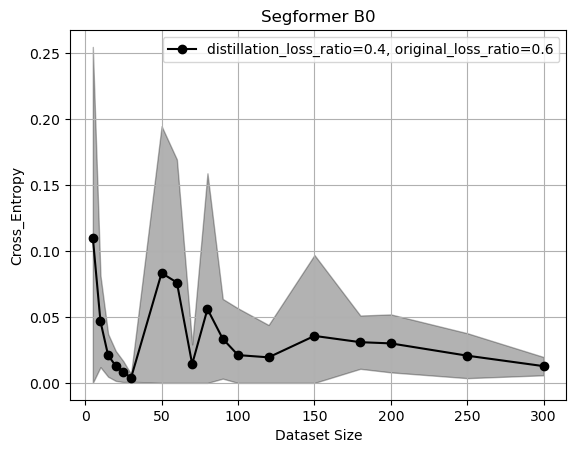

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()